# fbb scheleton notebook for PUI2016 HW6

In [497]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import seaborn
import statsmodels.formula.api as smf
import scipy.stats
#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


## An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
## So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

## Either obtain the data through the API or download the csv file, and move it to $PUIDATA

## However this datasets does not have the number of units. We can find that in the Pluto dataset.

## Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [498]:
#download, and move data to PUIDATA, and read data in 
nrg = pd.read_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
#os.system("unzip " + os.getenv("PUIDATA") + "/mn_mappluto_16v1.zip -d" + os.getenv("PUIDATA"))
bsize = gp.read_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")
nrg.head()

,Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [499]:
bsize.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [500]:
nrg.columns

Index(['Record Number', 'NYC Borough, Block, and Lot (BBL)',
       'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'],
      dtype='object')

In [501]:
bsize.columns

Index(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'UnitsRe

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20935f79b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2092bc90f0>]], dtype=object)

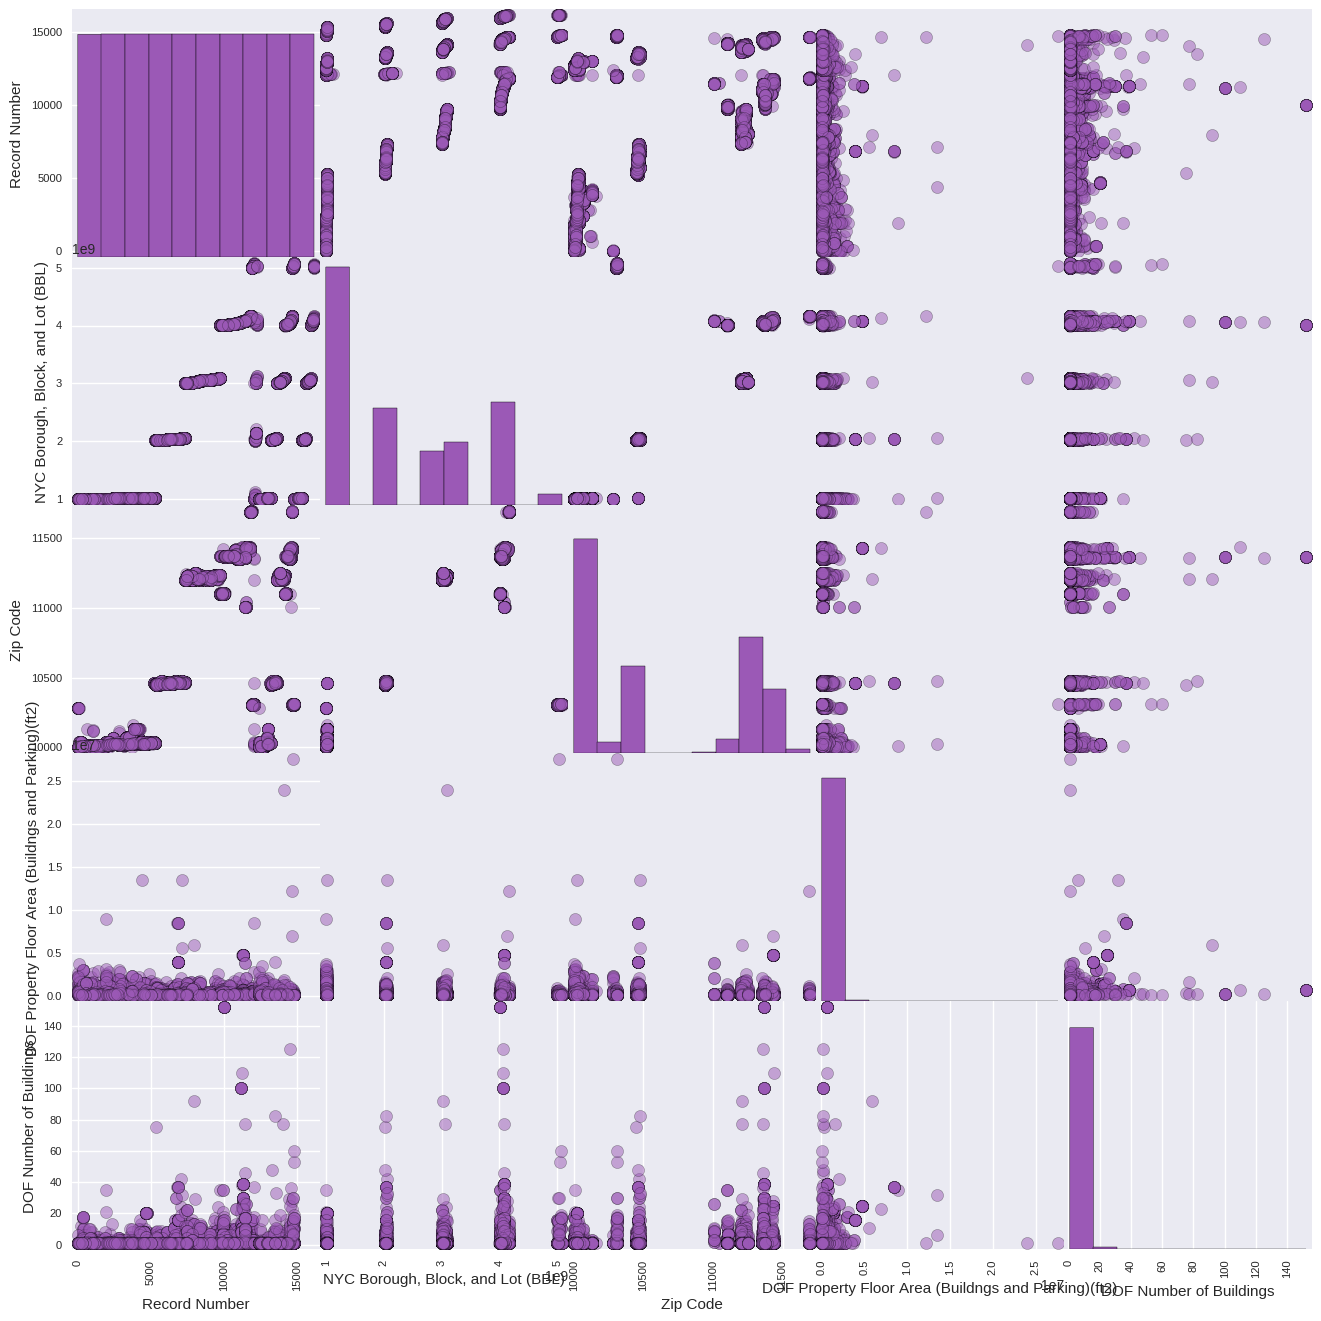

In [502]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16))

Figure 1: scatter matrix of all numerical values in the files.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.
Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.
This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..."
However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [503]:
# make sure you clean up your data and throw away columns you do not need!
nrg = nrg[['NYC Borough, Block, and Lot (BBL)', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]
bsize = bsize[['BBL', 'UnitsTotal', 'YearBuilt']]
print (nrg.head())
bsize.head()

   NYC Borough, Block, and Lot (BBL) Site EUI(kBtu/ft2)  \
0                       1.000410e+09                NaN   
1                       4.021460e+09                NaN   
2                       2.027620e+09                NaN   
3                       1.006700e+09                NaN   
4                       2.048300e+09                NaN   

  Reported Property Floor Area (Building(s)) (ft²)  
0                                           918919  
1                                              NaN  
2                                            64200  
3                                              NaN  
4                                            50000  


,BBL,UnitsTotal,YearBuilt
0,1.015450e+09,18,1920
1,1.007238e+09,50,1914
2,1.016800e+09,10,1910
3,1.013850e+09,32,1928
4,1.011970e+09,26,1900


In [504]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
        


Now for every column I care about I can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest. 

I can replace the entries that failed to be converted to 'NaN'
(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx) 

In [505]:
#nrg['Site EUI(kBtu/ft2)'].describe()

In [506]:
##check that your conversion worked: e.g.
#print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
#bsize.BBL.astype(float)
#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


In [507]:
#example
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')
#do it for however many columns you need
indx1 = (np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)']))
print ("invalid entries changed to NaN %d"%sum(indx1))
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx1] = float('NaN')

invalid entries changed to NaN 15513
invalid entries changed to NaN 15430


# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2092748a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2096765a90>]], dtype=object)

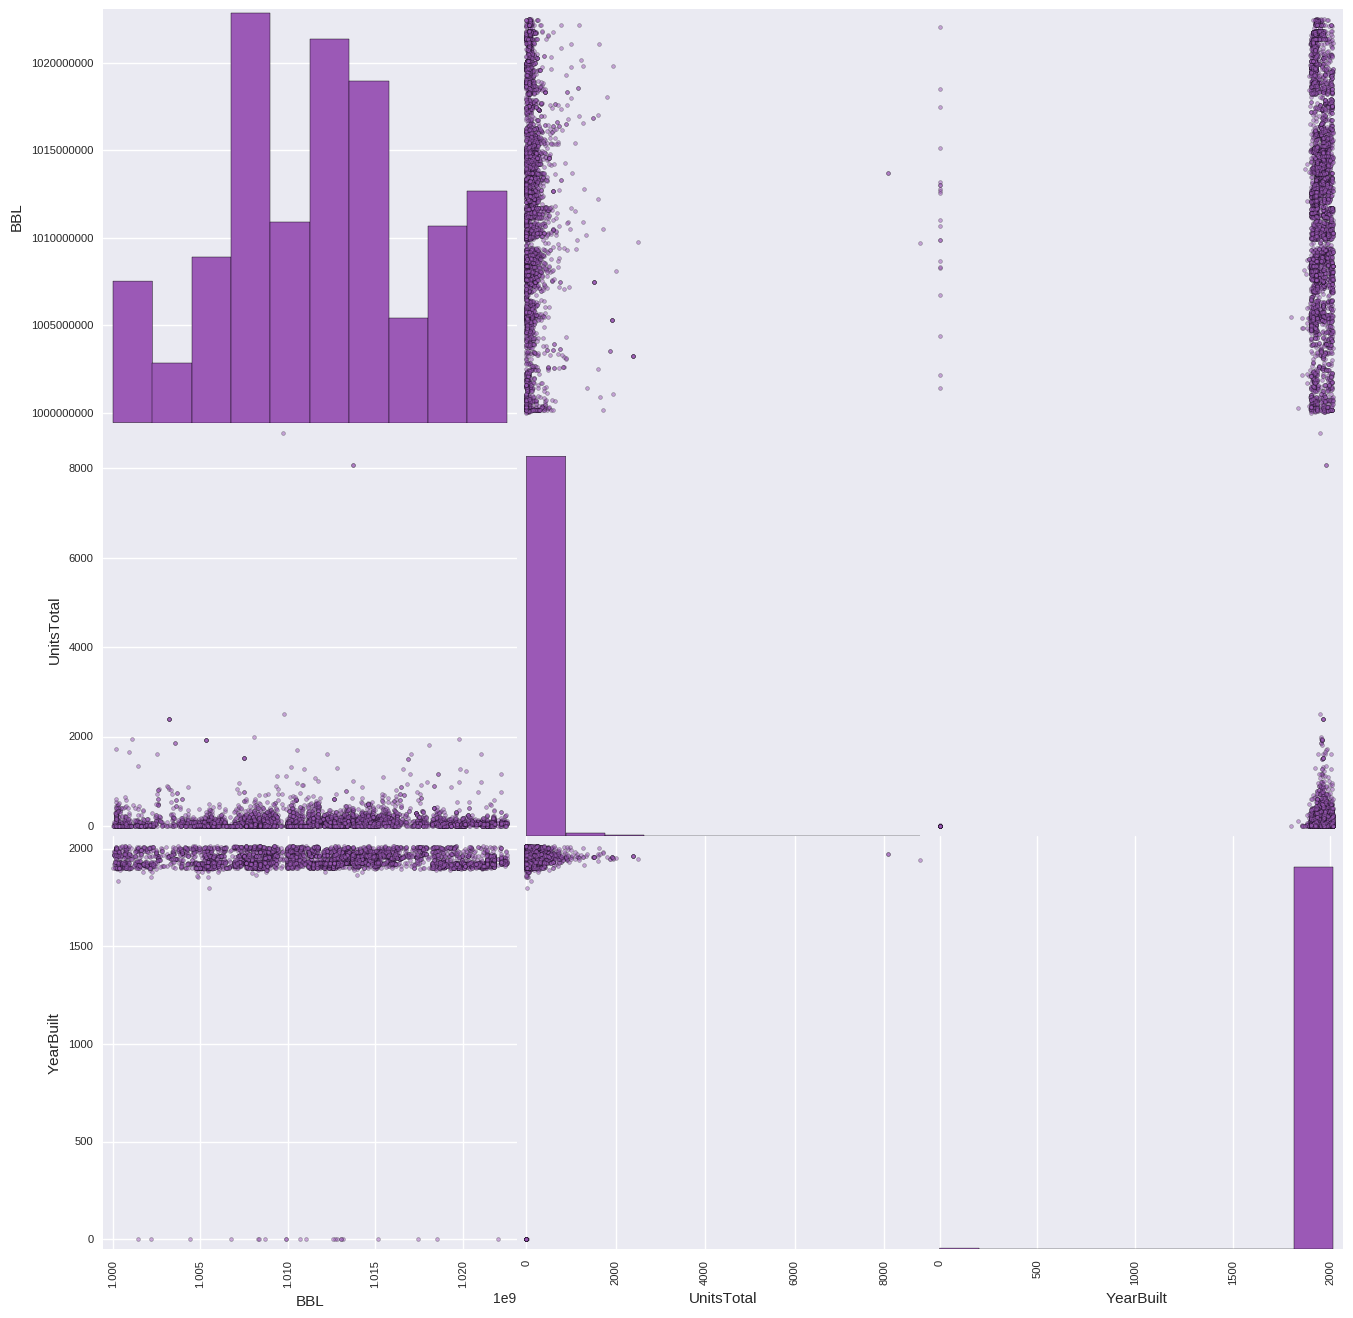

In [508]:
# prepare your BBL columns
nrg.columns =['BBL', 'SiteEUI', 'FloorArea']

#merge
bblnrgdata = pd.merge(nrg, bsize, on='BBL')

# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [509]:
bblnrgdata.head()

,BBL,SiteEUI,FloorArea,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,1,1987
1,1.004370e+09,NaN,NaN,4,1920
2,1.013110e+09,125.4,330000,56,1977
3,1.009220e+09,NaN,NaN,148,1963
4,1.007400e+09,NaN,68329,1,1920


In [510]:
bblnrgdata['TotalEnergy'] = bblnrgdata.SiteEUI.astype(float) * bblnrgdata.FloorArea.astype(float)
bblnrgdata.head()

,BBL,SiteEUI,FloorArea,UnitsTotal,YearBuilt,TotalEnergy
0,1.006700e+09,NaN,NaN,1,1987,NaN
1,1.004370e+09,NaN,NaN,4,1920,NaN
2,1.013110e+09,125.4,330000,56,1977,41382000.0
3,1.009220e+09,NaN,NaN,148,1963,NaN
4,1.007400e+09,NaN,68329,1,1920,NaN


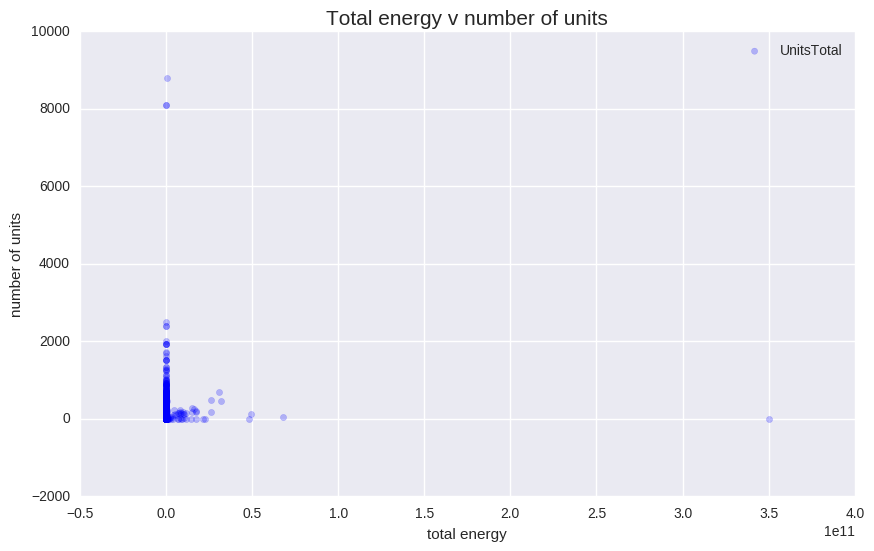

In [511]:
# first scatter plot
pl.figure(figsize=(10, 6))
pl.scatter(bblnrgdata.TotalEnergy, bblnrgdata.UnitsTotal, color='blue', alpha = 0.25)
pl.ylabel('number of units')
pl.xlabel('total energy')
pl.legend()
pl.title('Total energy v number of units', size = 15) 


## Caption: Plot is not very useful in this resolution 

(1, 1000)

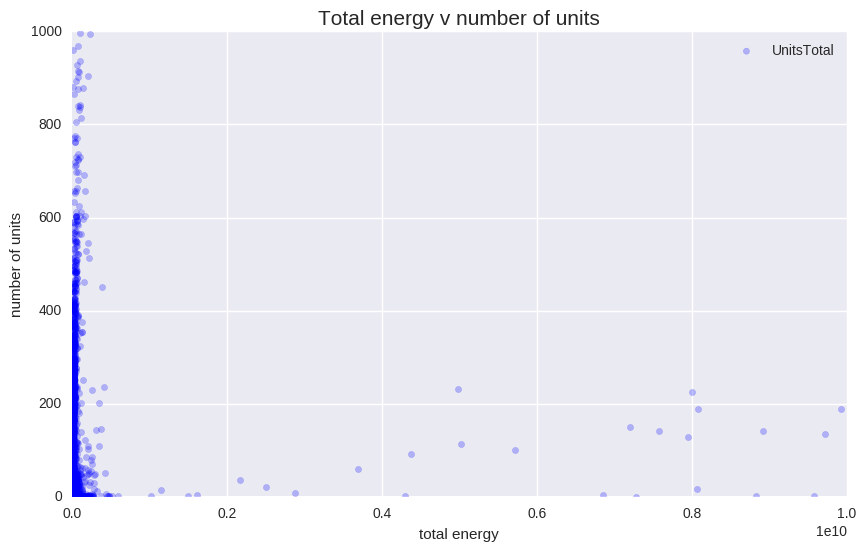

In [512]:
# zoomed in scatter plot

pl.figure(figsize=(10, 6))
pl.scatter(bblnrgdata.TotalEnergy, bblnrgdata.UnitsTotal, color='blue', alpha = 0.25)
pl.ylabel('number of units')
pl.xlabel('total energy')
pl.title('Total energy v number of units', size = 15) 
pl.legend()
pl.xlim(1, 1e10)
pl.ylim(1, 1000)

## Caption: Zoom of the plot

when the points in a plot all look scrunched against the axis 

**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



In [513]:
bblnrgdata.TotalEnergy.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    5.069000e+03
mean     2.136455e+08
std      5.245490e+09
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      3.501452e+11
Name: TotalEnergy, dtype: float64

In [514]:
bblnrgdata_cut = bblnrgdata[bblnrgdata.TotalEnergy>1]
bblnrgdata_cut.TotalEnergy.describe()

count    5.063000e+03
mean     2.138987e+08
std      5.248593e+09
min      5.344000e+03
25%      5.872633e+06
50%      9.359138e+06
75%      1.906361e+07
max      3.501452e+11
Name: TotalEnergy, dtype: float64

In [515]:
bblnrgdata_cut2 = bblnrgdata_cut[bblnrgdata_cut.UnitsTotal<1000]
bblnrgdata_cut3 = bblnrgdata_cut2[bblnrgdata_cut2.UnitsTotal>10]
bblnrgdata_cut3.describe()

,BBL,UnitsTotal,YearBuilt,TotalEnergy
count,4.237000e+03,4237.000000,4237.000000,4.237000e+03
mean,1.012380e+09,117.668397,1942.841869,1.235499e+08
std,5.470285e+06,127.015900,43.244365,1.734665e+09
min,1.000048e+09,11.000000,0.000000,5.344000e+03
25%,1.008410e+09,44.000000,1920.000000,5.865608e+06
50%,1.012610e+09,75.000000,1930.000000,8.993268e+06
75%,1.015420e+09,140.000000,1964.000000,1.717122e+07
max,1.022500e+09,997.000000,2015.000000,6.779388e+10


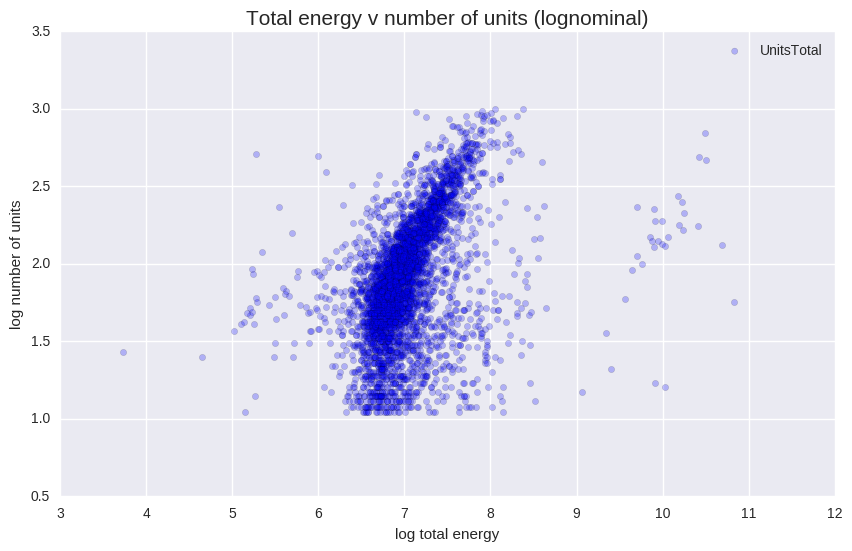

In [516]:
pl.figure(figsize=(10, 6))
pl.scatter(np.log10(bblnrgdata_cut3.TotalEnergy), np.log10(bblnrgdata_cut3.UnitsTotal), alpha= 0.25)
pl.ylabel('log number of units')
pl.xlabel('log total energy')
pl.legend()
pl.title('Total energy v number of units (lognominal)', size = 15) 

## Caption: Plot seems to have linerally relation, but techincally number of units is not a dependent variable, therefore this plot makes no sense.

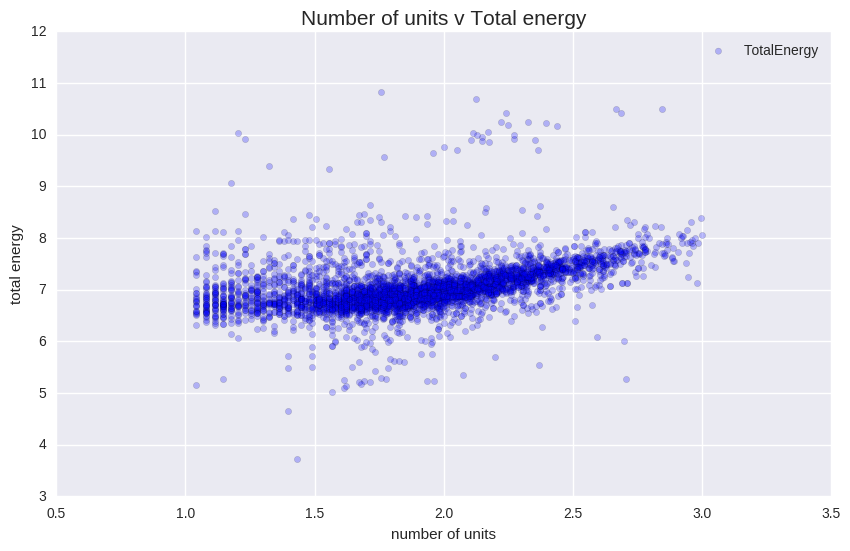

In [517]:
pl.figure(figsize=(10, 6))
pl.scatter(np.log10(bblnrgdata_cut3.UnitsTotal), np.log10(bblnrgdata_cut3.TotalEnergy), alpha=0.25)
pl.xlabel('number of units')
pl.ylabel('total energy')
pl.legend()
pl.title('Number of units v Total energy', size = 15) 

## Caption: Plot seems to have linerally relation, and techincally energy is a dependent variable, therefore this plot makes more sense.

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [518]:
bblnrgdata_cut3.loc[:,"logEnergy"]= np.log10(bblnrgdata_cut2.TotalEnergy)
bblnrgdata_cut3.loc[:,"logUnits"]= np.log10(bblnrgdata_cut2.UnitsTotal) 
bblnrgdata_cut3.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,BBL,UnitsTotal,YearBuilt,TotalEnergy,logEnergy,logUnits
count,4.237000e+03,4237.000000,4237.000000,4.237000e+03,4237.000000,4237.000000
mean,1.012380e+09,117.668397,1942.841869,1.235499e+08,7.031129,1.890692
std,5.470285e+06,127.015900,43.244365,1.734665e+09,0.481947,0.391808
min,1.000048e+09,11.000000,0.000000,5.344000e+03,3.727866,1.041393
25%,1.008410e+09,44.000000,1920.000000,5.865608e+06,6.768313,1.643453
50%,1.012610e+09,75.000000,1930.000000,8.993268e+06,6.953918,1.875061
75%,1.015420e+09,140.000000,1964.000000,1.717122e+07,7.234801,2.146128
max,1.022500e+09,997.000000,2015.000000,6.779388e+10,10.831190,2.998695


In [519]:
bblpoly = pd.DataFrame()
bblpoly['Units'] = np.arange(bblnrgdata_cut3.logUnits.min(), bblnrgdata_cut3.logUnits.max(), 0.1)
bblpoly.count()

Units    20
dtype: int64

In [520]:
lm = smf.ols(formula='logEnergy ~ logUnits', data = bblnrgdata_cut3).fit()
bblnrgdata_cut3.loc[:,"pred1"]= lm.params[1] * bblnrgdata_cut3.logUnits + lm.params[0]
pred = pd.DataFrame()
pred.loc[:,"pred1"]= lm.params[1] * bblpoly.Units + lm.params[0]
pred.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,pred1
0,6.604422
1,6.654665
2,6.704907
3,6.755149
4,6.805391


In [521]:
bblpoly2 = pd.DataFrame()
bblpoly2['Energy'] = np.arange(bblnrgdata_cut3.logEnergy.min(), bblnrgdata_cut3.logEnergy.max(), 0.1)
bblpoly2.count()

Energy    72
dtype: int64

In [522]:
lm2 = smf.ols(formula='logUnits ~ logEnergy', data = bblnrgdata_cut3).fit()
bblnrgdata_cut3.loc[:,"pred2"]= lm2.params[1] * bblnrgdata_cut3.logEnergy + lm2.params[0]
pred2 = pd.DataFrame()
pred2.loc[:,"pred1"]= lm2.params[1] * bblpoly2.Energy + lm2.params[0]
pred2.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,pred1
0,0.793811
1,0.827017
2,0.860223
3,0.893429
4,0.926635


## choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which variable has a 'sensible' distribution that allows you to fit a function to it: **you need your independent variable to span a large range, and to be spread somewhat evenly in the range, rather than just clustered in a spot** so in this case switching the independent and dependent variable may be a good idea.



1. **Fit a line** to Units vs Energy.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**. I provide a function for that or you can write your own. *Assume poisson statistics for the errors on the independent variable*. 
    The function is 
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value with x value $x_i$ model is the predction of your fit for $x_i$, 
    
    $data(x_i)$ 
    is your observation, 
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors??)
    
4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2+bx+c$ .

5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
    where Model1 is the least complex (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels.
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



# 1. Fit a line to Energy vs Units.

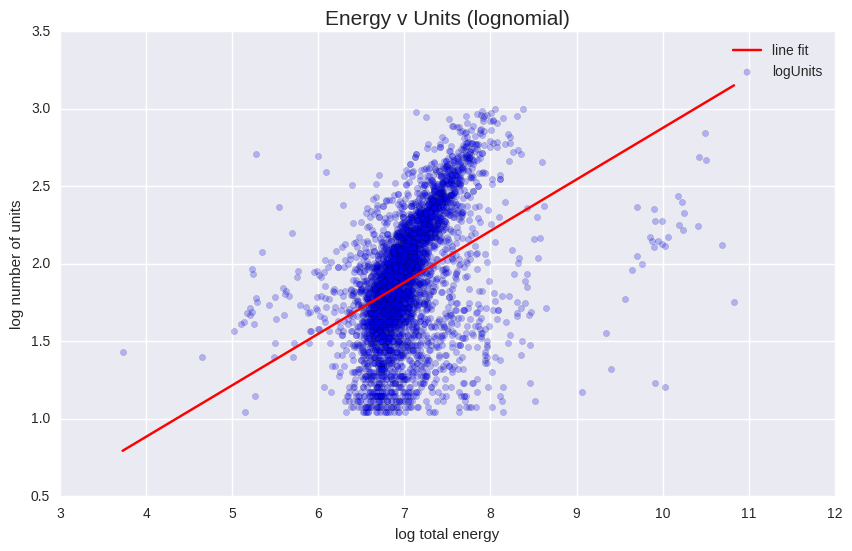

In [525]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)
pl.figure(figsize=(10, 6))
pl.scatter(bblnrgdata_cut3.logEnergy, bblnrgdata_cut3.logUnits, alpha=0.25)
pl.plot(bblpoly2.Energy, pred2.pred1, c="red", label='line fit')
pl.ylabel('log number of units')
pl.xlabel('log total energy')
pl.legend()
pl.title('Energy v Units (lognomial)', size = 15) 

## Caption: Line fit model does not seems the best fit for energy vs units 

In [526]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logUnits   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     848.0
Date:                Tue, 18 Oct 2016   Prob (F-statistic):          4.23e-170
Time:                        15:10:27   Log-Likelihood:                -1654.9
No. Observations:                4237   AIC:                             3314.
Df Residuals:                    4235   BIC:                             3326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.4441      0.080     -5.526      0.000        -0.602    -0.287
logEnergy      0.3321      0.011     29.121      0.000         0.310     0.354
==============================================================================
Omnibus:                      130.662   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.961
Skew:                          -0.431   Prob(JB):                     9.05e-32
Kurtosis:                       3.261   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [527]:
bblnrgdata_cut3.head()

,BBL,SiteEUI,FloorArea,UnitsTotal,YearBuilt,TotalEnergy,logEnergy,logUnits,pred1,pred2
2,1.013110e+09,125.4,330000,56,1977,41382000.0,7.616811,1.748188,6.959531,2.085174
16,1.008150e+09,117,364000,24,1954,42588000.0,7.629287,1.380211,6.774652,2.089317
18,1.005050e+09,82.1,235370,24,1926,19323877.0,7.286094,1.380211,6.774652,1.975356
19,1.021420e+09,137.69999999999999,64806,62,1924,8923786.2,6.950549,1.792392,6.981740,1.863935
20,1.021750e+09,103.2,62839,85,1920,6484984.8,6.811909,1.929419,7.050586,1.817898


In [528]:
#Chi Square
a = np.sum(((bblnrgdata_cut3.logUnits - bblnrgdata_cut3.pred2) ** 2) / bblnrgdata_cut3.logUnits)
print ('Chi Square value for energy v unit model is', a)

Chi Square value for energy v unit model is 332.621030972


In [529]:
#Checking Chi square with scipy 
scipy.stats.chisquare(f_obs=bblnrgdata_cut3.logUnits, f_exp=bblnrgdata_cut3.pred2)

Power_divergenceResult(statistic=277.81749683635383, pvalue=1.0)

# 2. Fit a line to Units vs Energy

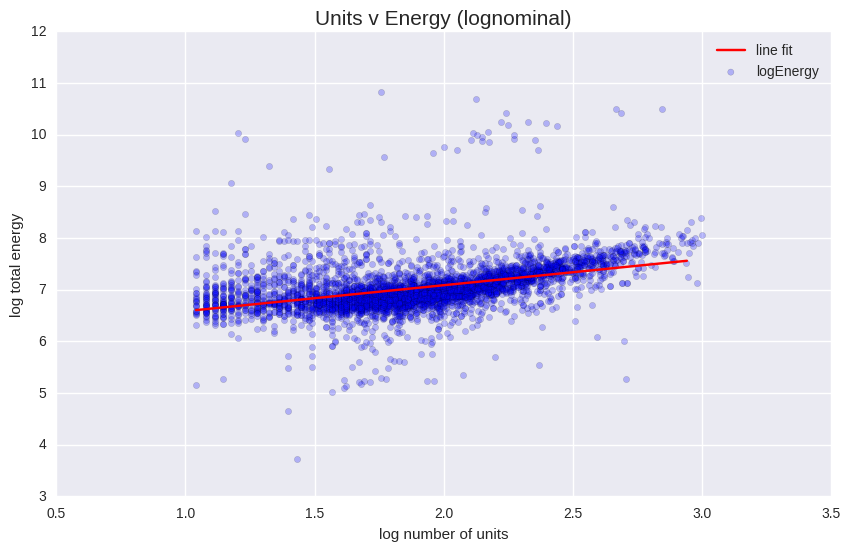

In [530]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)
pl.figure(figsize=(10, 6))
pl.scatter(bblnrgdata_cut3.logUnits, bblnrgdata_cut3.logEnergy, alpha=0.25)
pl.plot(bblpoly.Units, pred.pred1, c="red", label='line fit')
pl.xlabel('log number of units')
pl.ylabel('log total energy')
pl.legend()
pl.title('Units v Energy (lognominal)', size = 15) 

## Caption: Line fit model seems a better fit for units vs energy 

In [531]:
#Chi Square
b = np.sum(((bblnrgdata_cut3.logEnergy - bblnrgdata_cut3.pred1) ** 2) / bblnrgdata_cut3.logEnergy)
print ('Chi Square value for unit v energy model is', b)

Chi Square value for unit v energy model is 108.54704513


In [532]:
#Cross Checking Chi Square with scipy
scipy.stats.chisquare(f_obs=bblnrgdata_cut3.logEnergy, f_exp=bblnrgdata_cut3.pred1)

Power_divergenceResult(statistic=116.88240522128362, pvalue=1.0)

In [533]:
# my OLS summary. 
# Yours may be somewhat different depending on how you cut the data
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logEnergy   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     848.0
Date:                Tue, 18 Oct 2016   Prob (F-statistic):          4.23e-170
Time:                        15:10:28   Log-Likelihood:                -2532.2
No. Observations:                4237   AIC:                             5068.
Df Residuals:                    4235   BIC:                             5081.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.0812      0.033    182.547      0.000         6.016     6.147
logUnits       0.5024      0.017     29.121      0.000         0.469     0.536
==============================================================================
Omnibus:                     2273.853   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46297.723
Skew:                           2.111   Prob(JB):                         0.00
Kurtosis:                      18.634   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 3. Evaluate which is better by calculating the chi square.

In [534]:
print ('Chi square statistic value for energy v units is', a)
print ('Chi square statistic value for units v energy is', b)
print ('Since ', b, 'is smaller than ', a, 'therefore units v energy is better model.')

Chi square statistic value for energy v units is 332.621030972
Chi square statistic value for units v energy is 108.54704513
Since  108.54704513 is smaller than  332.621030972 therefore units v energy is better model.


# 4. Fit a 2nd degree polynomial

## Units v Energy

In [535]:
bblnrgdata_cut3['Units2'] = bblnrgdata_cut3.logUnits ** 2
lm3 = smf.ols(formula='logEnergy ~ logUnits + Units2', data = bblnrgdata_cut3).fit()
lm3.summary()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logEnergy   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     619.2
Date:                Tue, 18 Oct 2016   Prob (F-statistic):          1.24e-236
Time:                        15:10:31   Log-Likelihood:                -2375.3
No. Observations:                4237   AIC:                             4757.
Df Residuals:                    4234   BIC:                             4776.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.1207      0.118     69.101      0.000         7.890     8.351
logUnits      -1.7199      0.124    -13.837      0.000        -1.964    -1.476
Units2         0.5799      0.032     18.041      0.000         0.517     0.643
==============================================================================
Omnibus:                     2414.967   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60434.071
Skew:                           2.228   Prob(JB):                         0.00
Kurtosis:                      20.957   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [536]:
bblpoly['UR2'] = bblpoly.Units **2
bblpoly.head()

,Units,UR2
0,1.041393,1.084499
1,1.141393,1.302777
2,1.241393,1.541056
3,1.341393,1.799334
4,1.441393,2.077613


In [537]:
pred["pred3"]= lm3.params[1] * bblpoly.Units + lm3.params[2] * bblpoly.UR2 + lm3.params[0]
pred.head()

,pred1,pred3
0,6.604422,6.958636
1,6.654665,6.913237
2,6.704907,6.879437
3,6.755149,6.857235
4,6.805391,6.846633


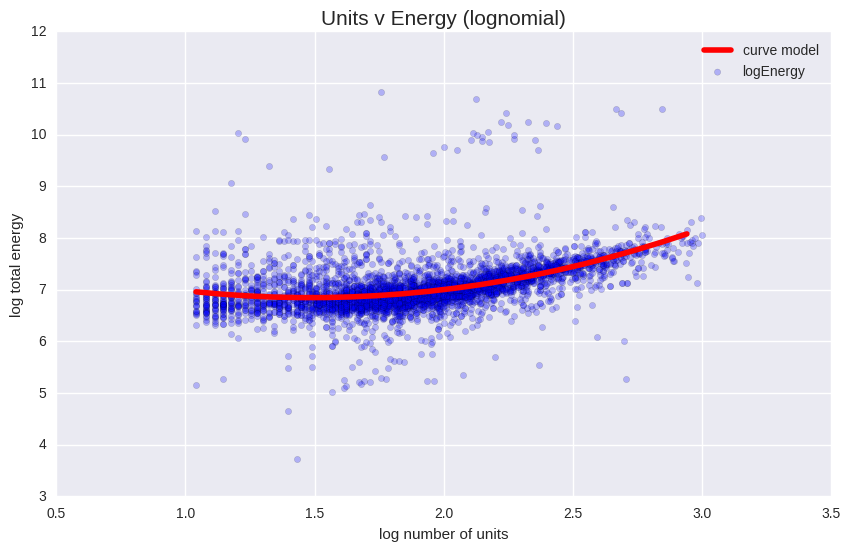

In [538]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)
pl.figure(figsize=(10, 6))
pl.scatter(bblnrgdata_cut3.logUnits, bblnrgdata_cut3.logEnergy, alpha=0.25)
pl.plot(bblpoly.Units, pred.pred3, '-', c="red", lw = 4, label='curve model')
pl.xlabel('log number of units')
pl.ylabel('log total energy')
pl.legend()
pl.title('Units v Energy (lognomial)', size = 15) 

## Caption: Polynominal model seems a better fit for units vs energy 

## Energy v Units

In [539]:
bblnrgdata_cut3['Energy2'] = bblnrgdata_cut3.logEnergy ** 2
lm4 = smf.ols(formula='logUnits ~ logEnergy + Energy2', data = bblnrgdata_cut3).fit()
lm4.summary()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logUnits   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     485.1
Date:                Tue, 18 Oct 2016   Prob (F-statistic):          2.13e-190
Time:                        15:10:33   Log-Likelihood:                -1604.5
No. Observations:                4237   AIC:                             3215.
Df Residuals:                    4234   BIC:                             3234.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.3684      0.397    -11.008      0.000        -5.146    -3.590
logEnergy      1.3939      0.106     13.175      0.000         1.186     1.601
Energy2       -0.0713      0.007    -10.094      0.000        -0.085    -0.057
==============================================================================
Omnibus:                       92.839   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.570
Skew:                          -0.340   Prob(JB):                     8.80e-23
Kurtosis:                       3.336   Cond. No.                     3.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [540]:
bblpoly2['ER2'] = bblpoly2.Energy **2
bblpoly2.head()

,Energy,ER2
0,3.727866,13.896988
1,3.827866,14.652562
2,3.927866,15.428135
3,4.027866,16.223708
4,4.127866,17.039281


In [541]:
pred2["pred4"]= lm4.params[1] * bblpoly2.Energy + lm4.params[2] * bblpoly2.ER2 + lm4.params[0]
pred2.head()

,pred1,pred4
0,0.793811,-0.162976
1,0.827017,-0.077462
2,0.860223,0.006626
3,0.893429,0.089288
4,0.926635,0.170523


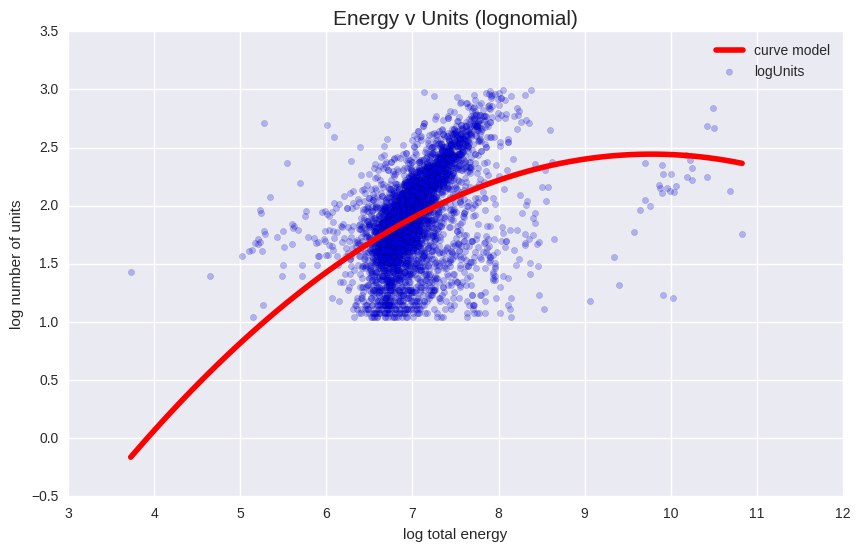

In [542]:
pl.figure(figsize=(10, 6))
pl.scatter(bblnrgdata_cut3.logEnergy, bblnrgdata_cut3.logUnits, alpha=0.25)
pl.plot(bblpoly2.Energy, pred2.pred4, '-', c="red", lw = 4, label='curve model')
pl.ylabel('log number of units')
pl.xlabel('log total energy')
pl.legend()
pl.title('Energy v Units (lognomial)', size = 15) 

## Caption: The polynomial model for Energy vs Units doesn't look like the best fit for the data. 

# 5. Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test.

## Null Hypothesis: line fit is a better fit to the data than polynomial fit

## Hypothesis: polynomial fit is a better fit than line fit

## alpha = 0.05

In [543]:
print ("LR : ", -2 * (-lm.llf - (-lm3.llf)))
print ("LR from statsmodels:", lm3.compare_lr_test(lm))

LR :  -313.805349513
LR from statsmodels: (313.80534951297159, 3.2379559949876506e-70, 1.0)


# LR (which is equivalent to pvalue) is 3.23e-70, which is significantly lower than the alpha for the null hypothesis, therefore null can be rejected.

## Conclusion: Polynomial fit is better 

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

In [551]:
def residuals(a,b,er):
    res = (((bblnrgdata_cut3.logEnergy - ((bblnrgdata_cut3.logUnits*a) + b))**2) / er).sum()
    return res

B = np.arange (-100, 100, 1)
A = np.arange(-50.0, 50.0, 0.5)

a = lm3.params[1]
b = lm3.params[0]
er = (bblnrgdata_cut3.logEnergy)/2

Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A): 
    for j,b in enumerate(B): 
        Lsurface[i][j] = np.nansum(residuals(a, b, er))

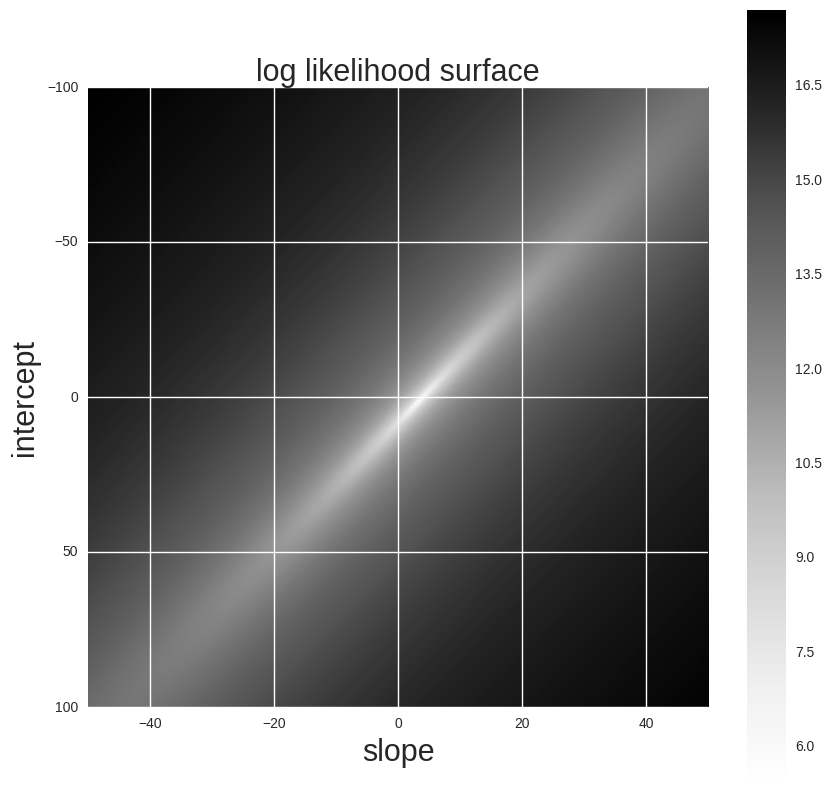

In [553]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()
#I don't know why is it black and white

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

In [545]:
bblnrgdata_cut3.describe()

,BBL,UnitsTotal,YearBuilt,TotalEnergy,logEnergy,logUnits,pred1,pred2,Units2,Energy2
count,4.237000e+03,4237.000000,4237.000000,4.237000e+03,4237.000000,4237.000000,4237.000000,4237.000000,4237.000000,4237.000000
mean,1.012380e+09,117.668397,1942.841869,1.235499e+08,7.031129,1.890692,7.031129,1.890692,3.728195,49.668989
std,5.470285e+06,127.015900,43.244365,1.734665e+09,0.481947,0.391808,0.196853,0.160035,1.515009,7.217857
min,1.000048e+09,11.000000,0.000000,5.344000e+03,3.727866,1.041393,6.604422,0.793811,1.084499,13.896988
25%,1.008410e+09,44.000000,1920.000000,5.865608e+06,6.768313,1.643453,6.906910,1.803422,2.700937,45.810061
50%,1.012610e+09,75.000000,1930.000000,8.993268e+06,6.953918,1.875061,7.023275,1.865054,3.515855,48.356969
75%,1.015420e+09,140.000000,1964.000000,1.717122e+07,7.234801,2.146128,7.159465,1.958324,4.605866,52.342347
max,1.022500e+09,997.000000,2015.000000,6.779388e+10,10.831190,2.998695,7.587813,3.152541,8.992173,117.314687


In [546]:
extra2 = bblnrgdata_cut3[['YearBuilt', 'UnitsTotal', 'TotalEnergy']]
extra2.head()

,YearBuilt,UnitsTotal,TotalEnergy
2,1977,56,41382000.0
16,1954,24,42588000.0
18,1926,24,19323877.0
19,1924,62,8923786.2
20,1920,85,6484984.8


In [547]:
extra2["age"]= 2016 - extra2.YearBuilt
extra2['energyperunit'] = (extra2.TotalEnergy / extra2.UnitsTotal) / 1000
extra2.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,YearBuilt,UnitsTotal,TotalEnergy,age,energyperunit
count,4237.000000,4237.000000,4.237000e+03,4237.000000,4.237000e+03
mean,1942.841869,117.668397,1.235499e+08,73.158131,1.323063e+03
std,43.244365,127.015900,1.734665e+09,43.244365,2.354834e+04
min,0.000000,11.000000,5.344000e+03,1.000000,1.979259e-01
25%,1920.000000,44.000000,5.865608e+06,52.000000,8.174039e+01
50%,1930.000000,75.000000,8.993268e+06,86.000000,1.126470e+02
75%,1964.000000,140.000000,1.717122e+07,96.000000,1.913439e+02
max,2015.000000,997.000000,6.779388e+10,2016.000000,1.189366e+06


In [548]:
extra2 = extra2[extra2.age<200]
extra2 = extra2[extra2.age>4]
extra2 = extra2[extra2.energyperunit<1000]
extra2.describe()

,YearBuilt,UnitsTotal,TotalEnergy,age,energyperunit
count,4048.000000,4048.000000,4.048000e+03,4048.000000,4048.000000
mean,1942.710227,120.132411,1.409072e+07,73.289773,160.956764
std,31.246587,127.979641,1.800857e+07,31.246587,154.745652
min,1836.000000,11.000000,5.344000e+03,5.000000,0.197926
25%,1920.000000,46.000000,5.766464e+06,52.000000,80.470666
50%,1929.000000,77.000000,8.684022e+06,87.000000,109.664844
75%,1964.000000,143.000000,1.538309e+07,96.000000,170.755466
max,2011.000000,997.000000,3.923141e+08,180.000000,995.958146


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


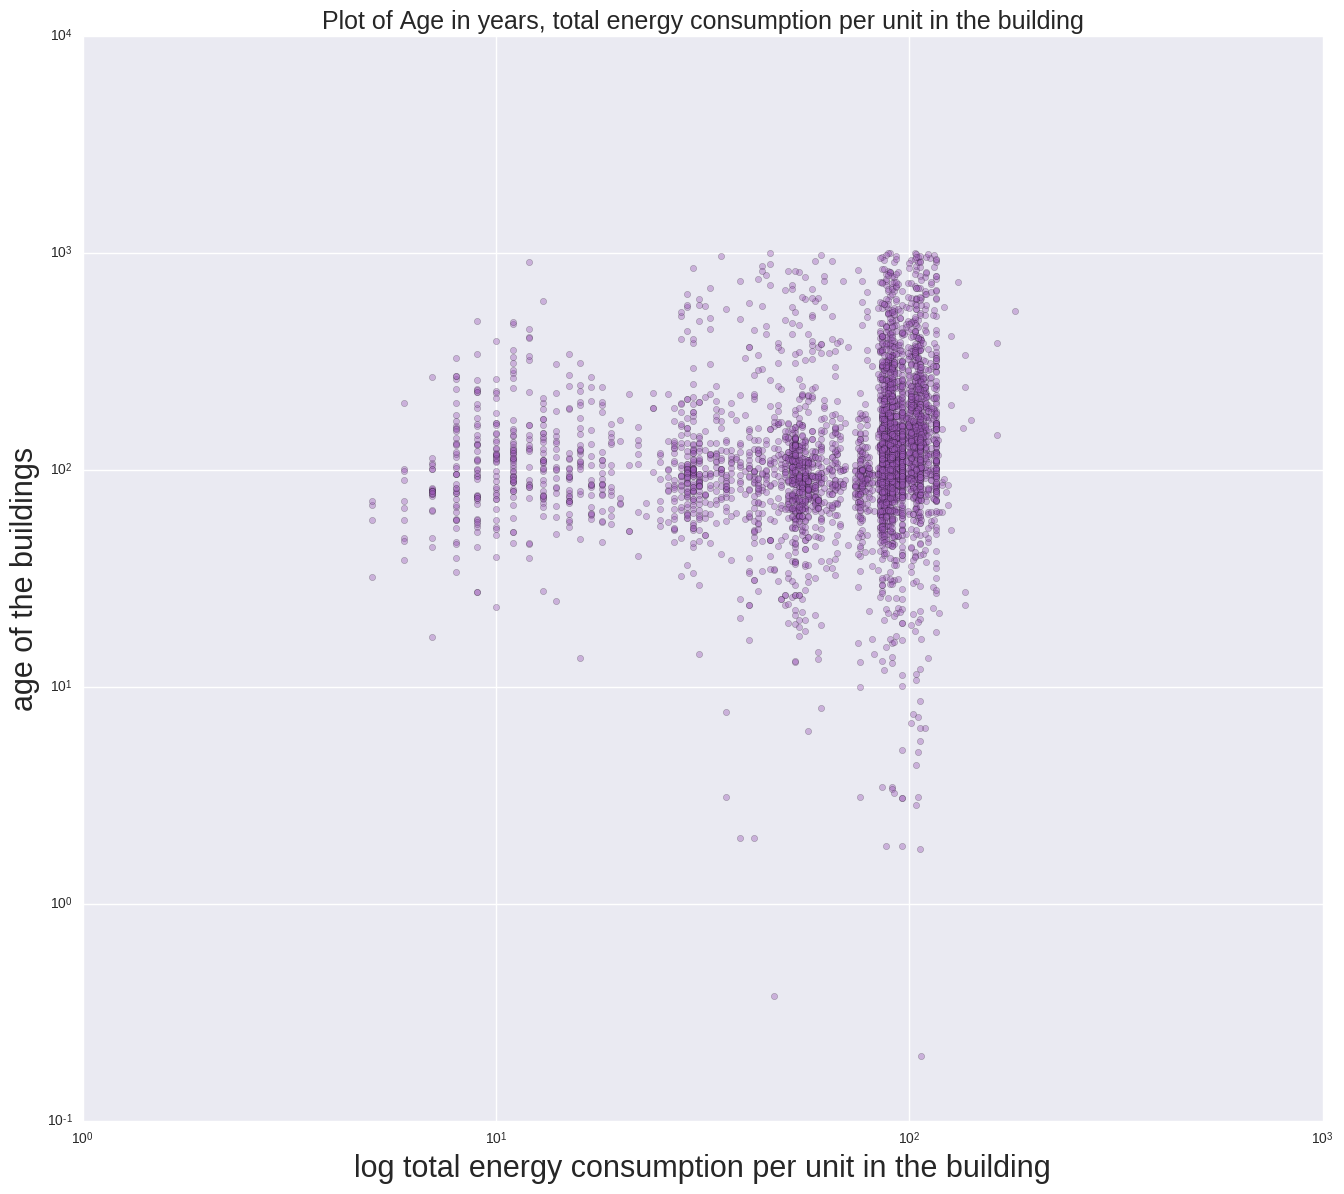

In [549]:
extra2.plot(kind='scatter',x='age',y='energyperunit',  figsize=(16, 14), alpha = 0.4, loglog=True)
pl.title('Plot of Age in years, total energy consumption per unit in the building', fontsize=18)
pl.ylabel("age of the buildings", fontsize=22)
pl.legend()
pl.xlabel("log total energy consumption per unit in the building", fontsize=22)